# Analysis of 4DSTEM data using pixstem

In [2]:
import numpy as np
import scipy
import pixstem.api as ps
import hyperspy.api as hs
import pixstem.io_tools as it
import matplotlib.pylab as plt
%matplotlib nbagg

# Load dataset using hyperspy and convert to pixstem object

In [7]:
#Load data using hyperspy and convert it to pixstem
# Use "s = it.signal_to_pixelated_stem(data, lazy=True)" for large datasets

data = hs.load("./Datos/11 SI data_20cm_CL1-2/Diffraction SI.dm4", lazy=True)
s = it.signal_to_pixelated_stem(data)
s

<LazyPixelatedSTEM, title: Diffraction SI, dimensions: (286, 286|256, 256)>

# Plot PACBED

We calculate the sum of all convergent electron diffraction patterns (4DSTEM images) for all probe positions. We can use this image to estimate the sample thickness 

<IPython.core.display.Javascript object>


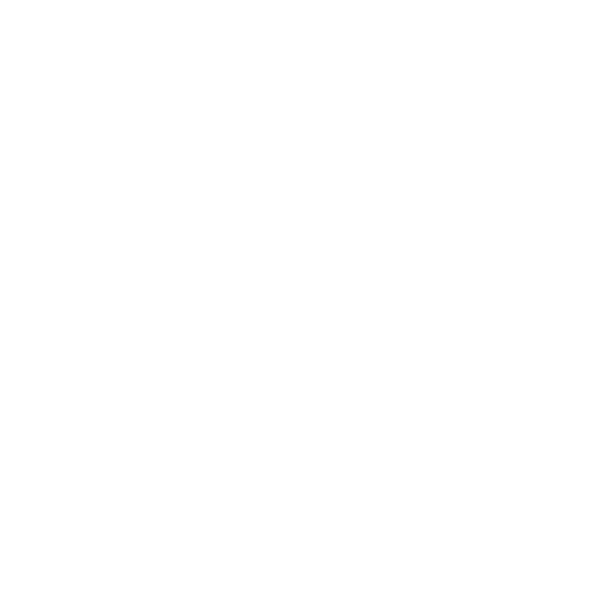

MemoryError: Unable to allocate array with shape (5360582656,) and data type float32

In [8]:
#Plot Position Averaged Covergenet Electron Diffraction Pattern (PACBED)

s_PACBED = data.sum()
    
fig = plt.figure(figsize=(6,6))
plt.imshow(s_PACBED, cmap='plasma')
plt.xticks([])
plt.yticks([])
plt.show()

s_PACBED.save('./Datos/11 SI data_20cm_CL1-2/s_PACED.tif')


# Visualize 4DSTEM data. 
We have a CBED pattern for each probe position. Use keyboard arrows or mouse to move around the navigator image


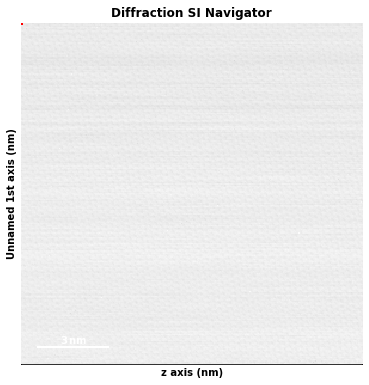

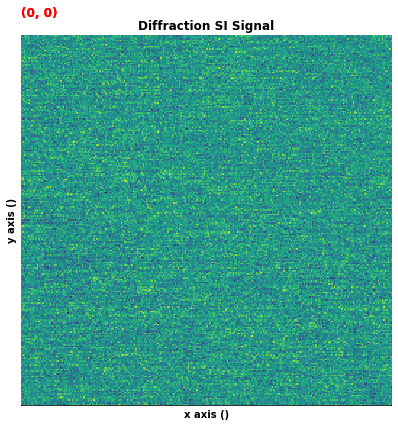

In [4]:
#Doesn't work well for very big datasets. Use GMS 3 for visualizing the 4D STEM data.

s.plot(colorbar=False, scalebar=False, axes_ticks=False, cmap='viridis',
       navigator_kwds=dict(colorbar=False, axes_ticks=False))

<IPython.core.display.Javascript object>


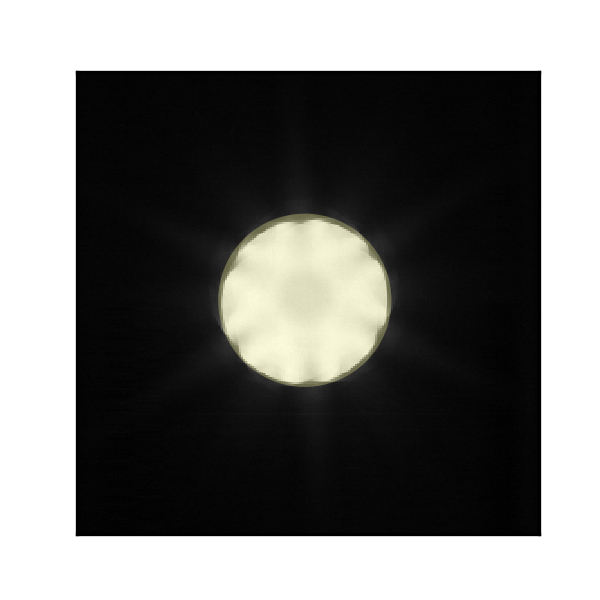

In [10]:
# This function plots a virtual Mask on the Diffraction Data
def PlotMask(Image, Position, Radius):
    myyellow = (256/256.,256/256.,153/256.)
    fig = plt.figure(figsize=(2,2), dpi=300)
    plt.imshow(Image, interpolation='none', cmap='gray')
    cir = plt.Circle((Position[0],Position[1]), radius=Radius, alpha =.3 ,
                     fc=myyellow)
    plt.gca().add_patch(cir)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
# Visualize virtual detectors on PACBED

center = np.array([126,126])
PlotMask (s_PACBED, center, 48)

# Visualize virtual detectors on 4DSTEM data

We can calculate and visualize virtual detectors on the 4DSTEM data. 
For adf input the center position of the 4DSTEM image and the angular range of the detector in pixels
For bf input the center position of the 4FSTEM image and the maximum angle of the detector in pixels

In [5]:
s_adf = s.virtual_annular_dark_field(126, 126, 60, 128, show_progressbar=True)
s_bf = s.virtual_bright_field(126, 126, 45, show_progressbar=True)

images = [s_adf, s_bf]
hs.plot.plot_images(images, label=['ADF', 'BF'],  tight_layout=True, 
                    colorbar=False, axes_decor='off')

[########################                ] | 60% Completed |  2min 48.1s


MemoryError: Unable to allocate 20.0 GiB for an array with shape (286, 286, 256, 256) and data type float32

# Center of Mass calculation for visualizing the atomic electric fields

The resultant images from the center of mass calculation are in pixels so we have to convert them to angular units (mrad) in order to calculate the electric field from the beam deflection

[########################################] | 100% Completed |  2min 24.2s


[<AxesSubplot:title={'center':'Center of Mass Y'}>,
 <AxesSubplot:title={'center':'Center of Mass X'}>,
 <AxesSubplot:title={'center':'Field Map'}>,
 <AxesSubplot:title={'center':'Field Magnitude'}>]

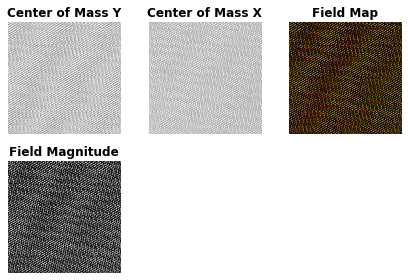

In [6]:
# Mask for the calculation of the center of mass (beam deflection)
mask = (126, 126, 50)
s_com = s.center_of_mass(mask=mask, show_progressbar=True)

# We convert the center of mass data to Numpy array in order to correct
# for the center offset. Offset = 4DSTEM image size / 2

offset = 126
com = np.asarray(s_com)
com = com - offset
com = com.astype('float32')

# We convert the data back to a pixstem DPC object and plot the data

s_com = ps.DPCSignal2D(com)
s_com = s_com.rotate_beam_shifts(270)
s_color = s_com.get_color_signal()
s_magnitude = s_com.get_magnitude_signal()

images = [s_com, s_color, s_magnitude]
hs.plot.plot_images(images, label=['Center of Mass Y','Center of Mass X','Field Map', 'Field Magnitude'],  
                    tight_layout=True, colorbar=False, axes_decor='off')

In [8]:
# We save the images to tif files

s_adf.save('/Michel/Datos/11 SI data_20cm_CL1-2/s_adf.tif')
s_bf.save('/Michel/Datos/11 SI data_20cm_CL1-2/s_bf.tif')
s_com.save('/Michel/Datos/11 SI data_20cm_CL1-2/s_com.tif')
s_color.save('/Michel/Datos/11 SI data_20cm_CL1-2/s_color.tif')
s_magnitude.save('/Michel/Datos/11 SI data_20cm_CL1-2/s_magnitude.tif')

Overwrite '/Michel/Datos/11 SI data_20cm_CL1-2/s_com.tif' (y/n)?
y
Overwrite '/Michel/Datos/11 SI data_20cm_CL1-2/s_color.tif' (y/n)?
y
Overwrite '/Michel/Datos/11 SI data_20cm_CL1-2/s_magnitude.tif' (y/n)?
y


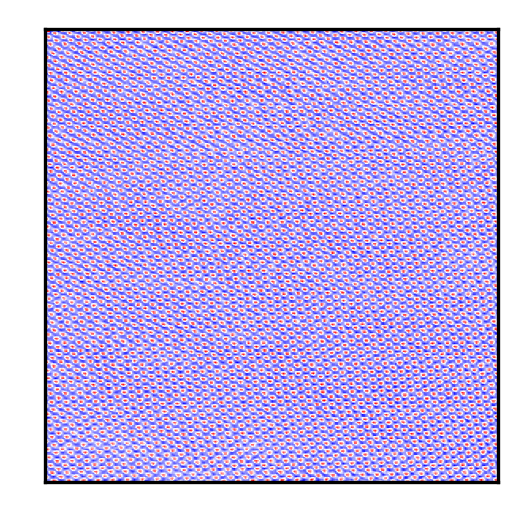

In [51]:
# Calculation of the divergence of the center of mass image.
# This image is directly proportional to the charge density

gradx = np.gradient(com[0])
grady = np.gradient(com[1])

div = gradx[1] + grady[0]
s_div = hs.signals.Signal2D(div)
s_div.save('/Michel/Datos/11 SI data_20cm_CL1-2/s_div.tif', overwrite=True)


fig = plt.figure(figsize=(2,2), dpi=300)
plt.imshow(div, cmap='bwr', vmin= -2.45, vmax=3.66)
plt.xticks([])
plt.yticks([])
plt.show()